In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import mne
from mne.time_frequency import tfr_multitaper, AverageTFRArray, EpochsTFRArray, tfr_array_morlet
import matplotlib.pyplot as plt
import seaborn as sns

mne.set_log_level(False)
sns.set_theme()
%matplotlib inline

C:\Users\DFM-RENDERING\AppData\Local\Temp\ipykernel_9004\1002421437.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [45]:
def read_file(path, order):
    frame = pd.read_csv(path, delimiter=',\s+', comment='%')
    info = mne.create_info([ 'channel5','channel7','trigger'], ch_types=[ 'eeg','eeg', 'stim'], sfreq=250)
    data = frame.values.T[order]
    data[-1] = (data[-1] == 1).astype(int) 
    raw = mne.io.RawArray(data, info)
    raw = raw.filter(l_freq=1, h_freq=40)
    raw = raw.notch_filter(50)
    events = mne.find_events(raw, output='step')
    
    start = events[::2, 0]
    types = events[::2, 2]
    times = events[1::2, 0] - start
    types[np.abs(times-25) < 5] = 0
    types[np.abs(times-50) < 5] = 1
    types[np.abs(times-75) < 5] = 2
    types[np.abs(times-100) < 5] = 3
    types[np.abs(times-125) < 5] = 4

    middle = np.zeros(start.shape[0], dtype=int)    
    events = np.concatenate([start[None], middle[None], types[None]], axis=0).T
    epochs = mne.Epochs(raw, events, tmin=-1, tmax=3, baseline=(-1, 0))
    return epochs

def compute_ci(data, confidence=0.95):
    n = data.shape[0]
    m, se = data.mean(axis=0), stats.sem(data, axis=0)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

def plot_epochs(ax, epochs, event, channel):
    data = epochs[event].get_data(tmin=0, copy=True)[:, channel, :-1]
    mean, ci = compute_ci(data)
    x = np.arange(data.shape[1]) / 250 - .2
    ax.plot(x, mean)
    ax.fill_between(x, mean-ci, mean+ci, alpha=.3)

def process_finche(files, order):
    epochs = [read_file(x, order) for x in files]
    epochs = mne.concatenate_epochs(epochs)

    return epochs


In [50]:
data_directory = 'Data/Audio_sleep/day4-12/' #12 just cmm, hvc
file4 = data_directory + 'OpenBCI-RAW-2024-09-25_17-52-27.Txt'
file5 = data_directory + 'OpenBCI-RAW-2024-09-25_18-08-03.Txt'
file6 = data_directory + 'OpenBCI-RAW-2024-09-25_18-27-05.Txt'

data_directory = 'Data/Audio_sleep/day5-11-hvc,cmm/'  # 11 hvc, cmm
file10 = data_directory + 'OpenBCI-RAW-2024-10-02_12-30-59.txt'
file11 = data_directory + 'OpenBCI-RAW-2024-10-02_12-47-47.txt'
file12 = data_directory + 'OpenBCI-RAW-2024-10-02_13-06-05.txt'

data_directory = 'Data/Audio_sleep/day5-11-all3/'  # 11 all
file13 = data_directory + 'OpenBCI-RAW-2024-10-02_13-25-16.txt'
file14 = data_directory + 'OpenBCI-RAW-2024-10-02_13-43-28.txt'

epochs = process_finche([file4, file5,file10, file11, file13, file14], [ 5,7, 16])



C:\Users\DFM-RENDERING\AppData\Local\Temp\ipykernel_9004\1440199917.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  frame = pd.read_csv(path, delimiter=',\s+', comment='%')
C:\Users\DFM-RENDERING\AppData\Local\Temp\ipykernel_9004\1440199917.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  frame = pd.read_csv(path, delimiter=',\s+', comment='%')
C:\Users\DFM-RENDERING\AppData\Local\Temp\ipykernel_9004\1440199917.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); y

In [29]:

def tf_plotN(epochs, channel, width=0.1, save_name = None):
    freqs = np.arange(1.0, 10.0, 1.0)
    fmin, fmax = freqs[[0, -1]]
    n_cycles = freqs / 2
    title = ['White Noise', 'BOS', 'Conspecific', 'Reverse BOS', '5K tone']
    fig, axes = plt.subplots(1, 5, figsize=(23, 4.5))  

    for i, event_type in enumerate(['0', '1', '2', '3', '4']):
        event_epochs = epochs[event_type]  
        power = event_epochs.compute_tfr(method="stockwell", freqs=(fmin, fmax), width=width)
        power.plot([channel], baseline=(-1, 0.0), mode="mean", show=False, axes=axes[i])

        axes[i].set_title(f"{title[int(event_type)]}",fontsize=19)
        axes[i].grid(False)
        axes[i].axvline(x=0, color='k', linewidth=4, linestyle='-') 
        axes[i].set_ylabel('Frequency (Hz)', fontsize=17)
        axes[i].set_xlabel('Time (s)', fontsize=17)
        axes[i].tick_params(axis='y', labelsize=13)
        axes[i].tick_params(axis='x', labelsize=13)

        plt.suptitle(save_name, fontsize=23, y=0.95)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.savefig(f"{save_name}.png", format='png', dpi=700)
    plt.savefig(f"{save_name}.eps", format='eps', dpi=700)

    plt.tight_layout()
    plt.show()


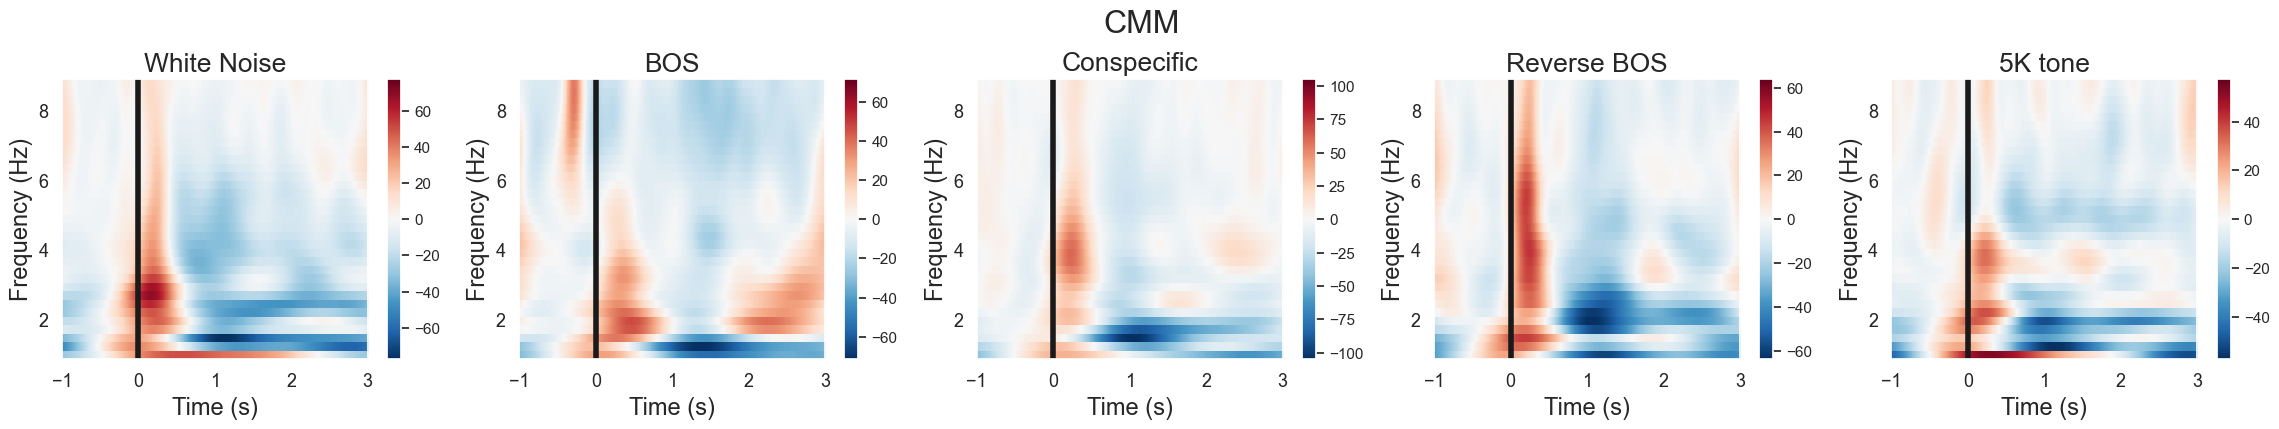

In [47]:
tf_plotN(epochs,0,0.25, "CMM")

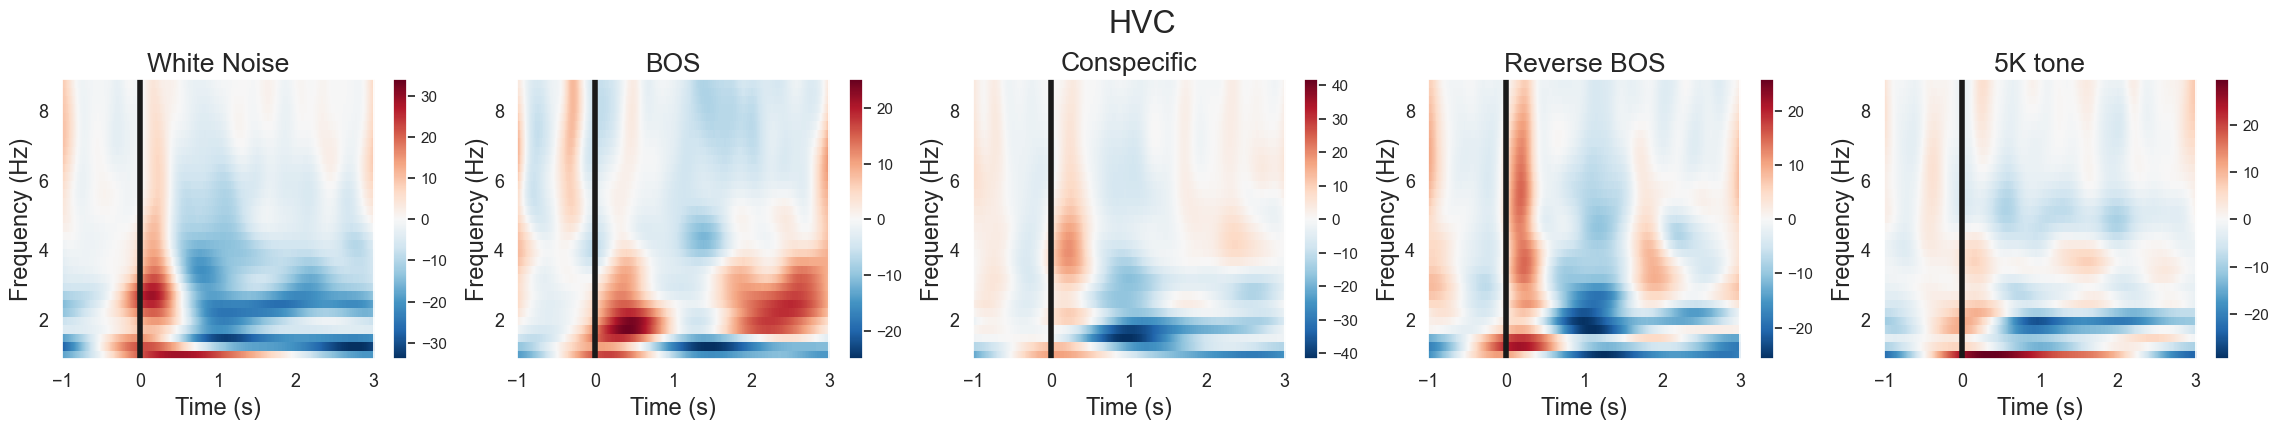

In [48]:
tf_plotN(epochs,1,0.25, "HVC")


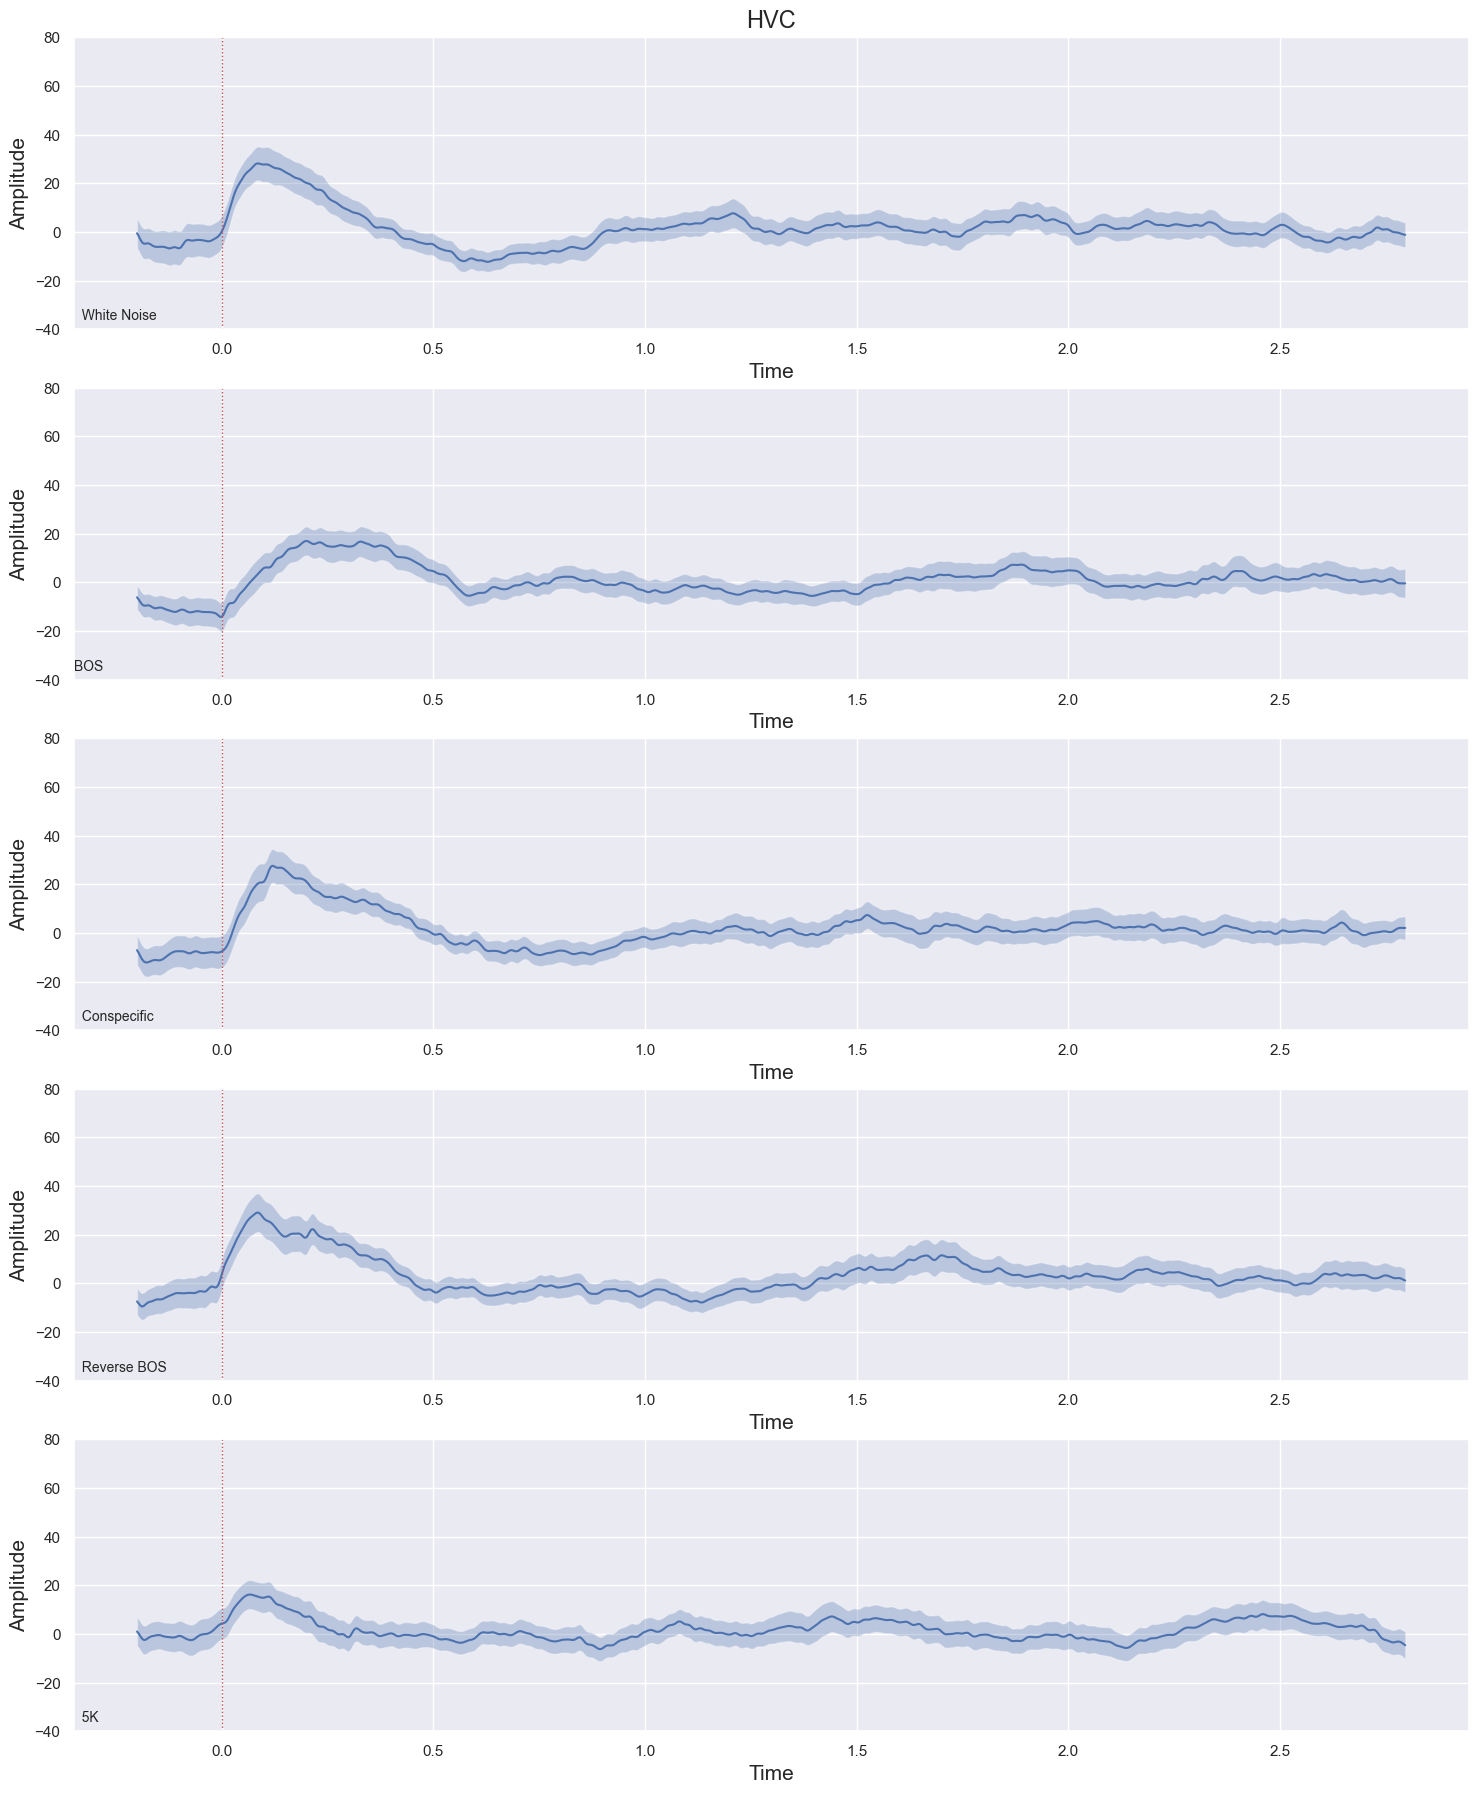

In [51]:
fig, ax = plt.subplots(5, 1, figsize=(18, 22))
plot_epochs(ax[0], epochs, '0', 1)
ax[0].set_title('HVC', fontsize=17,  y=1.1, pad=20,loc = 'center')
ax[0].set_title('  White Noise', fontsize=10,  y=0.1, pad=-14,loc = 'left')
ax[0].set_ylim([-40, +80])
ax[0].set_xlabel('Time', size = 15)
ax[0].set_ylabel('Amplitude',size = 15)
ax[0].axvline(x=0, color='r', linewidth=1, linestyle=':', label='Onset_3000 Hz')
  

plot_epochs(ax[1], epochs, '1', 1)
ax[1].set_title('BOS', fontsize=10,  y=0.1, pad=-14,loc = 'left')
ax[1].set_ylim([-40, +80])
ax[1].set_xlabel('Time',size = 15)
ax[1].set_ylabel('Amplitude',size = 15)
ax[1].axvline(x=0, color='r', linewidth=1, linestyle=':', label='Onset_3000 Hz')


plot_epochs(ax[2], epochs, '2', 1)
ax[2].set_title('  Conspecific', fontsize=10,  y=0.1, pad=-14,loc = 'left')
ax[2].set_ylim([-40, +80])
ax[2].set_xlabel('Time',size = 15)
ax[2].set_ylabel('Amplitude',size = 15)
ax[2].axvline(x=0, color='r', linewidth=1, linestyle=':', label='Onset_3000 Hz')

plot_epochs(ax[3], epochs, '3', 1)
ax[3].set_title('  Reverse BOS', fontsize=10,  y=0.1, pad=-14,loc = 'left')
ax[3].set_ylim([-40, +80])
ax[3].set_xlabel('Time',size = 15)
ax[3].set_ylabel('Amplitude',size = 15)
ax[3].axvline(x=0, color='r', linewidth=1, linestyle=':', label='Onset_3000 Hz')

plot_epochs(ax[4], epochs, '4', 1)
ax[4].set_title('  5K', fontsize=10,  y=0.1, pad=-14,loc = 'left')
ax[4].set_ylim([-40, +80])
ax[4].set_xlabel('Time',size = 15)
ax[4].set_ylabel('Amplitude',size = 15)
ax[4].axvline(x=0, color='r', linewidth=1, linestyle=':', label='Onset_3000 Hz')



#plt.savefig('ERP1_Frontal.eps', format='eps', dpi=1000)
plt.savefig('CMM.png', format='png', dpi=700)

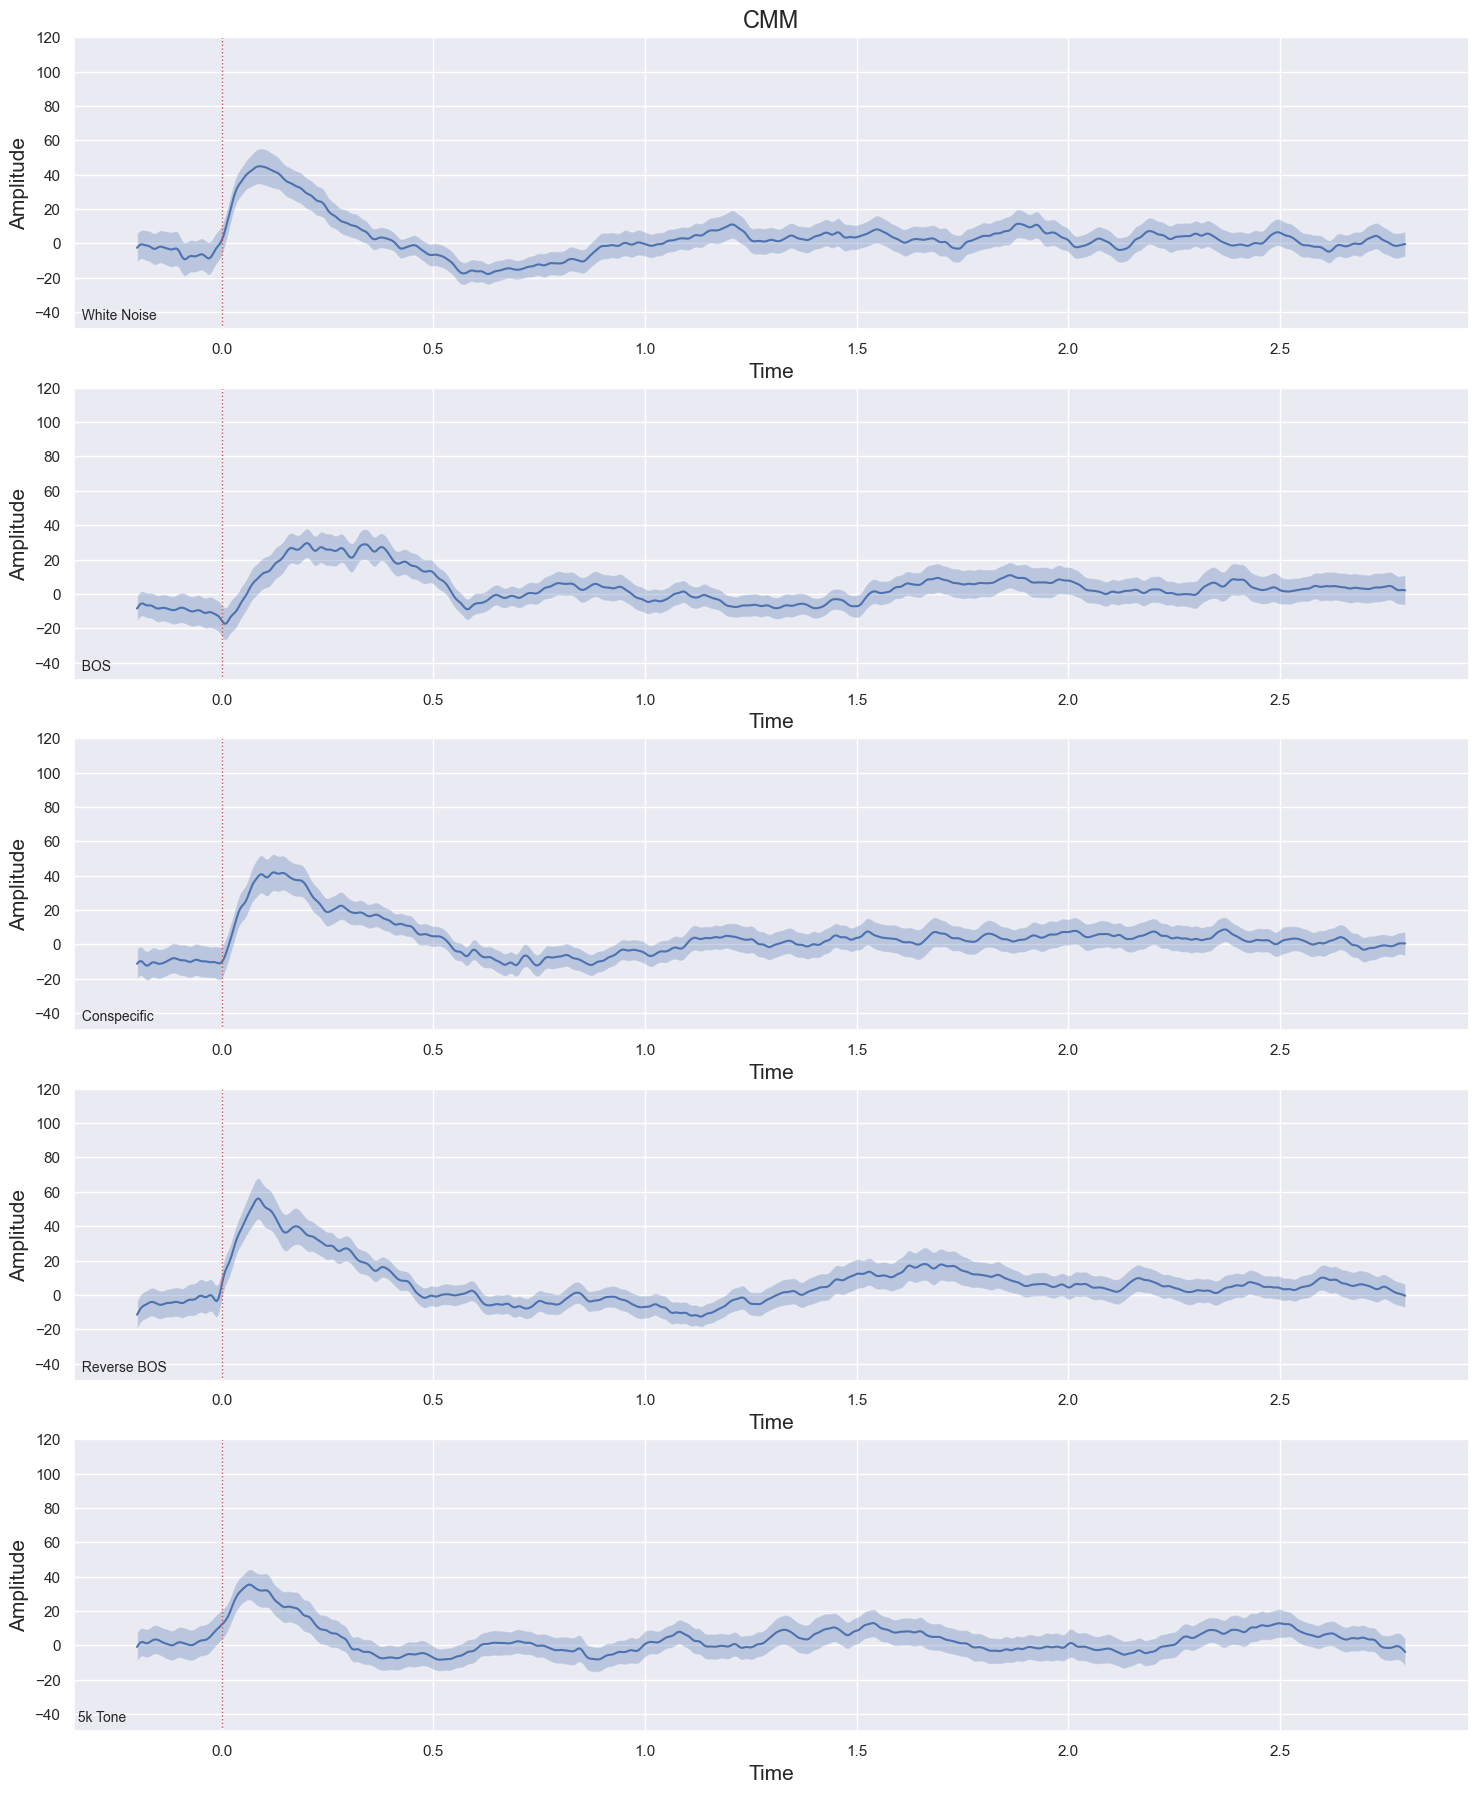

In [52]:
fig, ax = plt.subplots(5, 1, figsize=(18, 22))
plot_epochs(ax[0], epochs, '0', 0)
ax[0].set_title('CMM', fontsize=17,  y=1.1, pad=20,loc = 'center')
ax[0].set_title('  White Noise', fontsize=10,  y=0.1, pad=-14,loc = 'left')
ax[0].set_ylim([-50, +120])
ax[0].set_xlabel('Time', size = 15)
ax[0].set_ylabel('Amplitude',size = 15)
ax[0].axvline(x=0, color='r', linewidth=1, linestyle=':', label='Onset_3000 Hz')
  

plot_epochs(ax[1], epochs, '1', 0)
ax[1].set_title('  BOS', fontsize=10,  y=0.1, pad=-14,loc = 'left')
ax[1].set_ylim([-50, +120])
ax[1].set_xlabel('Time',size = 15)
ax[1].set_ylabel('Amplitude',size = 15)
ax[1].axvline(x=0, color='r', linewidth=1, linestyle=':', label='Onset_3000 Hz')


plot_epochs(ax[2], epochs, '2', 0)
ax[2].set_title('  Conspecific', fontsize=10,  y=0.1, pad=-14,loc = 'left')
ax[2].set_ylim([-50, +120])
ax[2].set_xlabel('Time',size = 15)
ax[2].set_ylabel('Amplitude',size = 15)
ax[2].axvline(x=0, color='r', linewidth=1, linestyle=':', label='Onset_3000 Hz')

plot_epochs(ax[3], epochs, '3', 0)
ax[3].set_title('  Reverse BOS', fontsize=10,  y=0.1, pad=-14,loc = 'left')
ax[3].set_ylim([-50, +120])
ax[3].set_xlabel('Time',size = 15)
ax[3].set_ylabel('Amplitude',size = 15)
ax[3].axvline(x=0, color='r', linewidth=1, linestyle=':', label='Onset_3000 Hz')

plot_epochs(ax[4], epochs, '4', 0)
ax[4].set_title(' 5k Tone ', fontsize=10,  y=0.1, pad=-14,loc = 'left')
ax[4].set_ylim([-50, +120])
ax[4].set_xlabel('Time',size = 15)
ax[4].set_ylabel('Amplitude',size = 15)
ax[4].axvline(x=0, color='r', linewidth=1, linestyle=':', label='Onset_3000 Hz')



#plt.savefig('ERP1_Frontal.eps', format='eps', dpi=1000)
plt.savefig('HVC.png', format='png', dpi=700)